In [1]:
import gym

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import random
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm
import pickle

from joblib import Parallel, delayed
import multiprocessing
from collections import namedtuple
from itertools import count

import cProfile
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable

from tqdm.notebook import tqdm

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

from matplotlib import rc
rc('font',**{'family':'sans-serif'})
# rc('text', usetex=True)
# rc('text.latex',preamble=r'\usepackage[utf8]{inputenc}')
# rc('text.latex',preamble=r'\usepackage[russian]{babel}')
rc('figure', **{'dpi': 300})

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Tic Tac Toe class

In [2]:
N_ROWS = 3
N_COLS = 3
N_WIN = 3

In [3]:
class TicTacToe(gym.Env):
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN, clone=None):
        if clone is not None:
            self.n_rows, self.n_cols, self.n_win = clone.n_rows, clone.n_cols, clone.n_win
            self.board = copy.deepcopy(clone.board)
            self.curTurn = clone.curTurn
            self.emptySpaces = None
            self.boardHash = None
        else:
            self.n_rows = n_rows
            self.n_cols = n_cols
            self.n_win = n_win

            self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i,j in zip(cur_marks[0], cur_marks[1]):
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
#             print('Wrong choice')
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

In [4]:
def plot_board(env, pi, showtext=True, verbose=True, fontq=20, fontx=60):
    '''Рисуем доску с оценками из стратегии pi'''
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    X, Y = np.meshgrid(np.arange(0, env.n_rows), np.arange(0, env.n_rows))
    Z = np.zeros((env.n_rows, env.n_cols)) + .01
    s, actions = env.getHash(), env.getEmptySpaces()
    if pi is not None and s in pi.Q:
        for i, a in enumerate(actions):
            Z[a[0], a[1]] = pi.Q[s][i]
    ax.set_xticks([])
    ax.set_yticks([])
    surf = ax.imshow(Z, cmap=plt.get_cmap('Accent', 10), vmin=-1, vmax=1)
    if showtext:
        for i,a in enumerate(actions):
            if pi is not None and s in pi.Q:
                ax.text( a[1] , a[0] , "%.3f" % pi.Q[s][i], fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
    for i in range(env.n_rows):
        for j in range(env.n_cols):
            if env.board[i, j] == -1:
                ax.text(j, i, "O", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
            if env.board[i, j] == 1:
                ax.text(j, i, "X", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
#     cbar = plt.colorbar(surf, ticks=[0, 1])
    ax.grid(False)
    plt.show()

def get_and_print_move(env, pi, s, actions, random=False, verbose=True, fontq=20, fontx=60):
    '''Делаем ход, рисуем доску'''
    plot_board(env, pi, fontq=fontq, fontx=fontx)
    if verbose and (pi is not None):
        if s in pi.Q:
            for i,a in enumerate(actions):
                print(i, a, pi.Q[s][i])
        else:
            print("Стратегия не знает, что делать...")
    if random:
        return np.random.randint(len(actions))
    else:
        return pi.getActionGreedy(s, len(actions))

In [5]:
def plot_test_game(env, pi1, pi2, random_crosses=False, random_naughts=True, verbose=True, fontq=20, fontx=60):
    '''Играем тестовую партию между стратегиями или со случайными ходами, рисуем ход игры'''
    done = False
    env.reset()
    while not done:
        s, actions = env.getHash(), env.getEmptySpaces()
        if env.curTurn == 1:
            a = get_and_print_move(env, pi1, s, actions, random=random_crosses, verbose=verbose, fontq=fontq, fontx=fontx)
        else:
            a = get_and_print_move(env, pi2, s, actions, random=random_naughts, verbose=verbose, fontq=fontq, fontx=fontx)
        observation, reward, done, info = env.step(actions[a])
        if reward == 1:
            print("Крестики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)
        if reward == -1:
            print("Нолики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)

### 1. Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.

In [6]:
from collections import defaultdict

In [7]:
def play(env: TicTacToe, agent_1, agent_2, p1_mode='random', p2_mode='random', verbose=False):
    env.reset()
    game_hash, empty_cells, player_turn = env.getState()
    is_finished = False
    
    while not is_finished:
        actions = get_available_actions_from_hash(game_hash)
#         print(actions, game_hash)
        if player_turn == 1:
            if p1_mode == 'random':
                action_idx = random.choice(actions)
    #             print(f'Choice: {action_idx}')
            elif p1_mode == 'agent':
                action_idx = np.argmax(agent_1.Q[game_hash])
        if player_turn == -1:
            if p2_mode == 'random' and player_turn == -1:
                action_idx = random.choice(actions)
    #             print(f'Choice: {action_idx}')
            elif p2_mode == 'agent':
                action_idx = np.argmax(agent_2.Q[game_hash])
#         print('Action id:', action_idx)
        action = env.action_from_int(action_idx)
        
        if verbose:
            env.printBoard()
        
        (game_hash, empty_cells, player_turn), reward, is_finished, _ = env.step(action)
        
    if verbose:
            env.printBoard()
        
    if reward == 1:
        return (1, 0)
    elif reward == -1:
        return (0, 1)
    else:
        return (0, 0)
    
def evaluate(env, agent_1, agent_2, n=1000, p1_mode='agent', p2_mode='agent'):
    player1_wins = []
    player2_wins = []
    for _ in range(n):
        r1, r2 = play(
            env, 
            agent_1, agent_2,
            p1_mode=p1_mode, 
            p2_mode=p2_mode
        )
        player1_wins.append(r1)
        player2_wins.append(r2)
    w1_p = np.mean(player1_wins)
    w2_p = np.mean(player2_wins)
    draw = 1 - w1_p - w2_p
    return w1_p, w2_p, draw

def get_available_actions_from_hash(game_hash):
    return np.where(np.array(list(game_hash)) == '1')[0]

def get_blocked_actions_from_hash(game_hash):
    return np.where(np.array(list(game_hash)) != '1')[0]

class Agent:
    def __init__(self, alpha, gamma, N=9):
        self.prev_state = None
        self.prev_action = None
        self.Q = defaultdict(lambda: np.zeros(N))
        self.alpha = alpha
        self.gamma = gamma
        
    def update_Q(self, state, reward):
        if self.prev_state is not None:
            self.Q[self.prev_state][self.prev_action] = self.Q[self.prev_state][self.prev_action] + \
                self.alpha * (reward + self.gamma * np.max(self.Q[state]) - self.Q[self.prev_state][self.prev_action])
        
    def save_state(self, state, action):
        self.prev_state = state
        self.prev_action = action

def Q_learn_step(env, agent_1: Agent, agent_2: Agent, epsilon=0.3):
    agents = {
        1: agent_1,
        -1: agent_2
    }
    prev = {
        -1: None,
        1: None
    }
    env.reset()
    agent_idx = 1
    game_hash, empty_cells, turn = env.getState()
    reward = 0
    is_finished = False
    
    while not is_finished:
        agent = agents[agent_idx]
        block_actions_idx = get_blocked_actions_from_hash(game_hash)
        agent.Q[game_hash][block_actions_idx] = float('-inf')
        actions = get_available_actions_from_hash(game_hash)
        if random.random() < epsilon:
            action_idx = random.choice(actions)
        else:
            action_idx = np.argmax(agent.Q[game_hash])
        action = env.action_from_int(action_idx)
        (game_hash, empty_cells, player_turn), reward, is_finished, _ = env.step(action)
        if prev[agent_idx] is None:
            agent.state = None
            agent.save_state(game_hash, action_idx) # если первый раз то просто записывает состояние
            prev[agent_idx] = True
        else:
            agents[-agent_idx].update_Q(game_hash, -reward)
            agents[agent_idx].save_state(game_hash, action_idx)
        agent_idx *= -1
    
    if reward == 1:
#         print('Cross wins')
        agents[1].update_Q(game_hash, 1)
        agents[-1].update_Q(game_hash, -1)
    
    elif reward == -1:
#         print('Zeros wins')
        agents[1].update_Q(game_hash, -1)
        agents[-1].update_Q(game_hash, 1)
        
        
def Q_learn(env, episodes=1e5, alpha=0.03, evaluate_every=1000, epsilon=0.1, gamma=1, verbose=False):
    p1_win = list()
    p2_win = list()
    game_hash, empty_cells, turn = env.getState()
    agent_1 = Agent(alpha, gamma, N=len(game_hash))
    agent_2 = Agent(alpha, gamma, N=len(game_hash))
    
    

    for i in tqdm(range(int(episodes)), disable=not verbose):
        Q_learn_step(env, agent_1, agent_2, epsilon)
        if (i + 1) % evaluate_every == 0 or i == 0:
            res_p1 = evaluate(env, agent_1, agent_2, n=200, p1_mode='agent', p2_mode='random')[0]
            res_p2 = evaluate(env, agent_1, agent_2, n=200, p1_mode='random', p2_mode='agent')[1]
            
            p1_win.append(res_p1)
            p2_win.append(res_p2)
            
            
    return agent_1, agent_2, p1_win, p2_win

        


In [8]:
env = TicTacToe(N_ROWS, N_COLS, N_WIN)
env.reset()

In [9]:
EPOCHS = 1e5

In [10]:
a1, a2, p1_stats, p2_stats = Q_learn(env, alpha=0.009, episodes=EPOCHS, verbose=True, epsilon=0.3)

  0%|          | 0/100000 [00:00<?, ?it/s]

In [11]:
# Check both agents, are they trying to win?
play(env, a1, a2, p1_mode='agent', p2_mode='agent', verbose=True)

-------------
|   |   |   | 
-------------
|   |   |   | 
-------------
|   |   |   | 
-------------
-------------
| x |   |   | 
-------------
|   |   |   | 
-------------
|   |   |   | 
-------------
-------------
| x | o |   | 
-------------
|   |   |   | 
-------------
|   |   |   | 
-------------
-------------
| x | o | x | 
-------------
|   |   |   | 
-------------
|   |   |   | 
-------------
-------------
| x | o | x | 
-------------
| o |   |   | 
-------------
|   |   |   | 
-------------
-------------
| x | o | x | 
-------------
| o | x |   | 
-------------
|   |   |   | 
-------------
-------------
| x | o | x | 
-------------
| o | x | o | 
-------------
|   |   |   | 
-------------
-------------
| x | o | x | 
-------------
| o | x | o | 
-------------
| x |   |   | 
-------------


(1, 0)

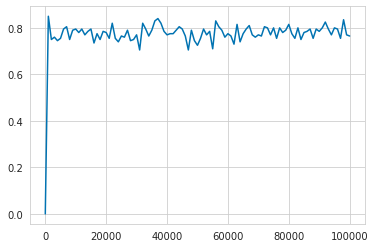

In [12]:
plt.plot(list(range(0, int(EPOCHS) + 1, 10 ** 3)), p1_stats)
plt.title('Крестики против рандома')
plt.xlabel('Доля побед')
plt.ylabel('Количество итераций обучения')
plt.show()

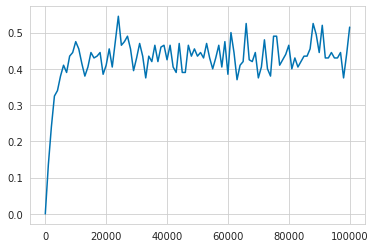

In [13]:
plt.plot(list(range(0, int(EPOCHS) + 1, 10 ** 3)), p2_stats)
plt.title('Нолики против рандома')
plt.xlabel('Доля побед')
plt.ylabel('Количество итераций обучения')
plt.show()

## 2. Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5.

In [14]:
env = TicTacToe(n_rows=4, n_cols=4, n_win=4)
env.reset()

In [15]:
EPOCHS = 1e6

In [16]:
a1, a2, p1_stats, p2_stats = Q_learn(env, alpha=0.02, episodes=EPOCHS, verbose=True, epsilon=0.3)

  0%|          | 0/1000000 [00:00<?, ?it/s]

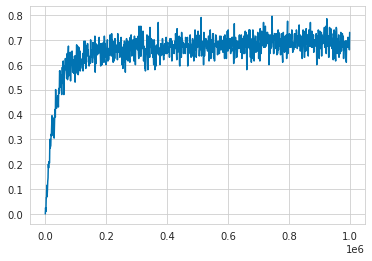

In [17]:
plt.plot(list(range(0, int(EPOCHS + 1), 10 ** 3)), p1_stats)
plt.title('Крестики (Х) против рандома')
plt.xlabel('Доля побед')
plt.ylabel('Количество итераций обучения')
plt.show()

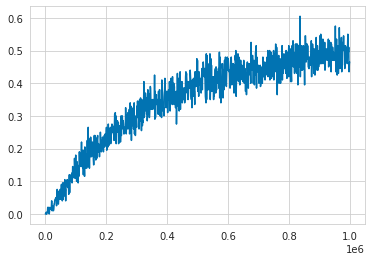

In [18]:
plt.plot(list(range(0, int(EPOCHS + 1), 10 ** 3)), p2_stats)
plt.title('Нолики (О) против рандома')
plt.xlabel('Доля побед')
plt.ylabel('Количество итераций обучения')
plt.show()

### Часть вторая: добавим нейронных сетей

#### Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов. Замечание: скорее всего, experience replay потребуется сразу же.

In [19]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def store(self, exptuple):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = exptuple
        self.position = (self.position + 1) % self.capacity
       
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)
    
    

In [20]:
class DQN_3(nn.Module):
    def __init__(self, hidden_dim=256, in_chanels=3):
        super().__init__()
        self.conv1 = nn.Conv2d(in_chanels, hidden_dim, kernel_size=(in_chanels, in_chanels))
        self.linear1 = nn.Linear(hidden_dim, hidden_dim)
        self.lenear2 = nn.Linear(hidden_dim, in_chanels ** 2)
        
    def forward(self, x):
        y = self.conv1(x)
        y = F.relu(y)
        y = y.squeeze(-1).squeeze(-1)
        y = self.linear1(y)
        y = F.relu(y)
        y = self.lenear2(y)
        return y
    
    def get_action(self, state):
        self.eval()
        state = hash_to_tensor(state)
        action = self(state.unsqueeze(0)).detach().max(1)[1][0].item()
        return action
    
class DQN_4(nn.Module):
    def __init__(self, hidden_dim=64, in_chanels=3):
        super().__init__()
        self.conv1 = nn.Conv2d(in_chanels, hidden_dim, kernel_size=(3, 3))
        self.conv2 = nn.Conv2d(hidden_dim, hidden_dim * 2, kernel_size=(2, 2))
        self.linear1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.lenear2 = nn.Linear(hidden_dim, 16)
        
    def forward(self, x):
        y = self.conv1(x)
        y = F.relu(y)
        y = self.conv2(y)
        y = F.relu(y)
        y = y.squeeze(-1).squeeze(-1)
        y = self.linear1(y)
        y = F.relu(y)
        y = self.lenear2(y)
        return y
    
    def get_action(self, state):
        self.eval()
        state = hash_to_tensor(state)
        action = self(state.unsqueeze(0)).detach().max(1)[1][0].item()
        return action
    
def hash_to_tensor(s):
    s = np.array([int(c) for c in s])
    size = int(np.sqrt(len(s)))
    crosses = np.where(s==2, 1, 0).reshape(size, size)
    zeros = np.where(s==0, 1, 0).reshape(size, size)
    empty_spaces = np.where(s==1, 1, 0).reshape(size, size)
    return torch.tensor(np.stack([crosses, zeros, empty_spaces]), dtype=torch.float32).reshape(3, size, size)

In [21]:
def play_model(env, model_1, model_2, p1_mode='random', p2_mode='random', verbose=False):
    env.reset()
    game_hash, empty_cells, player_turn = env.getState()
    is_finished = False

    with torch.no_grad():
        while not is_finished:
            actions = get_available_actions_from_hash(game_hash)
            if player_turn == 1:
                if p1_mode == 'random':
                    action_idx = random.choice(actions)
                elif p1_mode == 'agent':
                    action_idx = model_1.get_action(game_hash)
            if player_turn == -1:
                if p2_mode == 'random':
                    action_idx = random.choice(actions)
                elif p2_mode == 'agent':
                    action_idx = model_2.get_action(game_hash)
            action = env.action_from_int(action_idx)

            if verbose:
                env.printBoard()
        
            (game_hash, empty_cells, player_turn), reward, is_finished, _ = env.step(action)
        
    if verbose:
            env.printBoard()
                    
    if reward == 1:
        return (1, 0)
    elif reward == -1:
        return (0, 1)
    else:
        return (0, 0)

def evaluate_model(env, model_1, model_2, n=1000, p1_mode='random', p2_mode='random'):
    player1_wins = []
    player2_wins = []
    for _ in range(n):
        r1, r2 = play_model(
            env, 
            model_1, model_2,
            p1_mode=p1_mode, 
            p2_mode=p2_mode
        )
        player1_wins.append(r1)
        player2_wins.append(r2)
    w1_p = np.mean(player1_wins)
    w2_p = np.mean(player2_wins)
    draw = 1 - w1_p - w2_p
    return w1_p, w2_p, draw

In [22]:
class Player:
    def __init__(self, memory_capacity=200_000):
        self.state = None
        self.action = None
        self.reward = None
        self.memory = ReplayMemory(capacity=memory_capacity)
    
    def add_replay(self, next_state, action, reward):
        
        next_state = hash_to_tensor(next_state)
        if self.state is not None:
            self.memory.store((self.state, next_state, [self.action], [reward]))
        self.state = next_state
        self.action = action
        
    def reset(self):
        self.state = None
        self.action = None   

In [23]:
# player_dict_example = {
#     'model': model,
#     'player': player,
#     'optimizer': optimizer,
# }

def get_action(model, game_hash, epsilon):
    if random.random() < epsilon:
        actions = get_available_actions_from_hash(game_hash)
        action = random.choice(actions)
    else:
        action = model.get_action(game_hash)
    return action

def train_on_batch(players_dict, player_idx, loss_func, batch_size=128, gamma=1):
    player = players_dict[player_idx]['player']
    model = players_dict[player_idx]['model']
    optimizer = players_dict[player_idx]['optimizer']
    
    if len(player.memory) < batch_size:
        return
    
    replays = player.memory.sample(batch_size)
    batch_state, batch_next_state, batch_action, batch_reward = zip(*replays)
    
    
    batch_state = torch.stack(batch_state)
    batch_next_state = torch.stack(batch_next_state)
    batch_action = torch.tensor(batch_action, dtype=torch.long)
    batch_reward = torch.tensor(batch_reward).flatten()
    
    model.train()
    Q = model(batch_state).gather(1, batch_action).flatten()
    Qmax = model(batch_next_state).detach().max(dim=1)[0]
    Qnext = batch_reward + (gamma * Qmax)
    
    loss = loss_func(Q, Qnext)

    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return loss.item()


def play_episode(env, players_dict, epsilon=0.3):
    env.reset()
    game_hash, empty_cells, player_turn = env.getState()
    is_finished = False
    players_dict[1]['player'].reset()
    players_dict[-1]['player'].reset()
    player_idx = 1
    
    while not is_finished:
        player = players_dict[player_idx]['player']
        model = players_dict[player_idx]['model']
        action = get_action(model, game_hash, epsilon)
        player.add_replay(game_hash, action, 0)
        player_idx *= -1
        (game_hash, empty_cells, player_turn), reward , is_finished, _ = env.step(env.action_from_int(action))
        
    if reward == -10:
        player.add_replay(game_hash, action, reward)
    else:
        players_dict[1]['player'].add_replay(game_hash, action, reward)
        players_dict[-1]['player'].add_replay(game_hash, action, -reward)

In [24]:
def train(env, epochs, model_1, model_2, opt1, opt2, loss_func, batch_size=256, epsilon=0.3, gamma=1., in_channels=3, eval_every=100):
    env.reset()
    
    player_1 = Player()
    player_2 = Player()
    player_dict_1 = {
        'model': model_1,
        'player': player_1,
        'optimizer': opt1,
    }
    player_dict_2 = {
        'model': model_2,
        'player': player_2,
        'optimizer': opt2,
    }
    players_dict = {1: player_dict_1, -1: player_dict_2}
    
    results_dict = {
        1: defaultdict(list),
        2: defaultdict(list)
    }
    results_dict[2]['iter'] = results_dict[1]['iter'] # For saving memory
    for i in tqdm(range(epochs)):
        play_episode(env, players_dict, epsilon=epsilon)
        
        l1 = train_on_batch(players_dict, 1, loss_func=loss_func, batch_size=batch_size, gamma=gamma)
        l2 = train_on_batch(players_dict, -1, loss_func=loss_func, batch_size=batch_size, gamma=gamma)
        
        if l1:
            results_dict[1]['loss'].append(l1)
        if l2:
            results_dict[2]['loss'].append(l2)
            
        if (i + 1) % eval_every == 0 or i == 0:
            res_p1 = evaluate_model(env, model_1, model_2, n=500, p1_mode='agent', p2_mode='random')[0]
            res_p2 = evaluate_model(env, model_1, model_2, n=500, p1_mode='random', p2_mode='agent')[1]
            
            results_dict[1]['eval_wins'].append(res_p1)
            results_dict[2]['eval_wins'].append(res_p2)
            results_dict[1]['epoch'].append(i)
            
            # print(f'Epoch {i + 1}\n X loss: {l1}, X wins: {res_p1}\n O loss: {l2}, O wins: {res_p2}')
            # print('\n<', '=' * 16, '<\n')
            
            
    return results_dict
    
    

In [25]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')

#### DQN 3x3x3

In [26]:
lr = 5e-6
reg_alpha = 9e-7
hidden_dim = 256
loss_func = F.l1_loss

In [27]:
model_1 = DQN_3(in_chanels=3, hidden_dim=hidden_dim)
opt1 = optim.Adam(model_1.parameters(), lr=lr, weight_decay=reg_alpha)

model_2 = DQN_3(in_chanels=3, hidden_dim=hidden_dim)
opt2 = optim.Adam(model_2.parameters(), lr=lr, weight_decay=reg_alpha)

In [28]:
env = TicTacToe(N_ROWS, N_COLS, N_WIN)
env.reset()

In [29]:
results = train(env, 15000, model_1, model_2, opt1, opt2, loss_func=loss_func, eval_every=200, epsilon=0.44, batch_size=256)

  0%|          | 0/15000 [00:00<?, ?it/s]

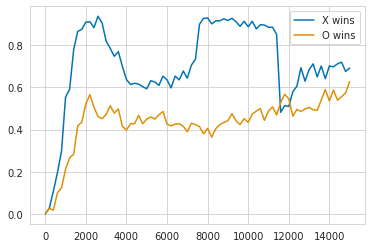

In [30]:
plt.plot(results[1]['epoch'], results[1]['eval_wins'], label='X wins random')
plt.plot(results[1]['epoch'], results[2]['eval_wins'], label='O wins random')
plt.legend()
plt.title('Доля побед обученного агента против рандома')
plt.xlabel('Доля побед')
plt.ylabel('Количество эпох')
plt.show()

#### DQN 4x4x4

In [31]:
lr = 5e-6
reg_alpha = 9e-7
hidden_dim = 128
# loss_func = F.l1_loss

model_1 = DQN_4(in_chanels=3, hidden_dim=hidden_dim)
opt1 = optim.Adam(model_1.parameters(), lr=lr, weight_decay=reg_alpha)

model_2 = DQN_4(in_chanels=3, hidden_dim=hidden_dim)
opt2 = optim.Adam(model_2.parameters(), lr=lr, weight_decay=reg_alpha)

In [32]:
env = TicTacToe(4, 4, 4)
env.reset()

In [33]:
results = train(env, 30000, model_1, model_2, opt1, opt2, loss_func=loss_func, eval_every=1000, epsilon=0.4, batch_size=512)

  0%|          | 0/30000 [00:00<?, ?it/s]

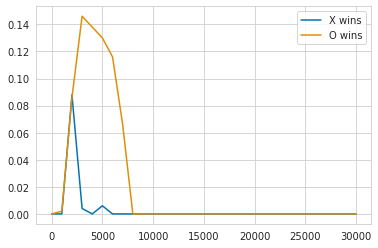

In [34]:
plt.plot(results[1]['epoch'], results[1]['eval_wins'], label='X wins')
plt.plot(results[1]['epoch'], results[2]['eval_wins'], label='O wins')
plt.title('Доля побед обученного агента против рандома')
plt.xlabel('Доля побед')
plt.ylabel('Количество эпох')
plt.legend()
plt.show()

### Dueling DQN
Реализуйте Double DQN и/или Dueling DQN.

In [35]:
env = TicTacToe(N_ROWS, N_COLS, N_WIN)
env.reset()

In [36]:
class DuelingDQN_3(nn.Module):
    def __init__(self, in_chanels=3, hidden_dim=256):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=in_chanels, out_channels=hidden_dim, kernel_size=(3, 3))
    
        self.V = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
        )
        
        self.A = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 9),
        )
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = x.squeeze(-1).squeeze(-1)
        A = self.A(x)
        V = self.V(x)
        Q = V + (A - A.mean(dim=1, keepdim=True).expand(x.size(0), 9))
        return Q

    def get_action(self, state):
        self.eval()
        state = hash_to_tensor(state)
        action = self(state.unsqueeze(0)).detach().max(1)[1][0].item()
        return action

In [41]:
lr = 4e-6
reg_alpha = 6e-7
hidden_dim = 512
loss_func = F.l1_loss

In [42]:
model_1 = DuelingDQN_3(in_chanels=3, hidden_dim=hidden_dim)
opt1 = optim.Adam(model_1.parameters(), lr=lr, weight_decay=reg_alpha)

model_2 = DuelingDQN_3(in_chanels=3, hidden_dim=hidden_dim)
opt2 = optim.Adam(model_2.parameters(), lr=lr, weight_decay=reg_alpha)

In [43]:
results = train(env, 37113, model_1, model_2, opt1, opt2, loss_func=loss_func, eval_every=1000, epsilon=0.4, batch_size=512)

  0%|          | 0/37113 [00:00<?, ?it/s]

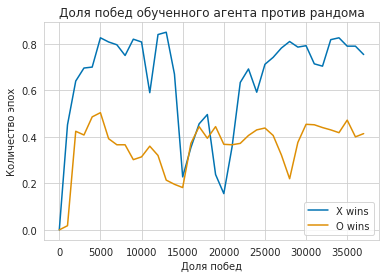

In [44]:
plt.plot(results[1]['epoch'], results[1]['eval_wins'], label='X wins')
plt.plot(results[1]['epoch'], results[2]['eval_wins'], label='O wins')
plt.title('Доля побед обученного агента против рандома')
plt.xlabel('Доля побед')
plt.ylabel('Количество эпох')
plt.legend()
plt.show()

Выводы:


1.   Очевидно методы с использованием нейронных сетей показали себя намного лучше, но Q метод на основе статистики показал сравнимый результат хоть так и не смог догнать методы с использованием нейросетей.
2.   Все обучается очень долго, надо было параллелить как вы и рекомендовали.


P.S. Простите, дальше я не осилил по причине нехватки времени, хотя и так жутко стыдно.